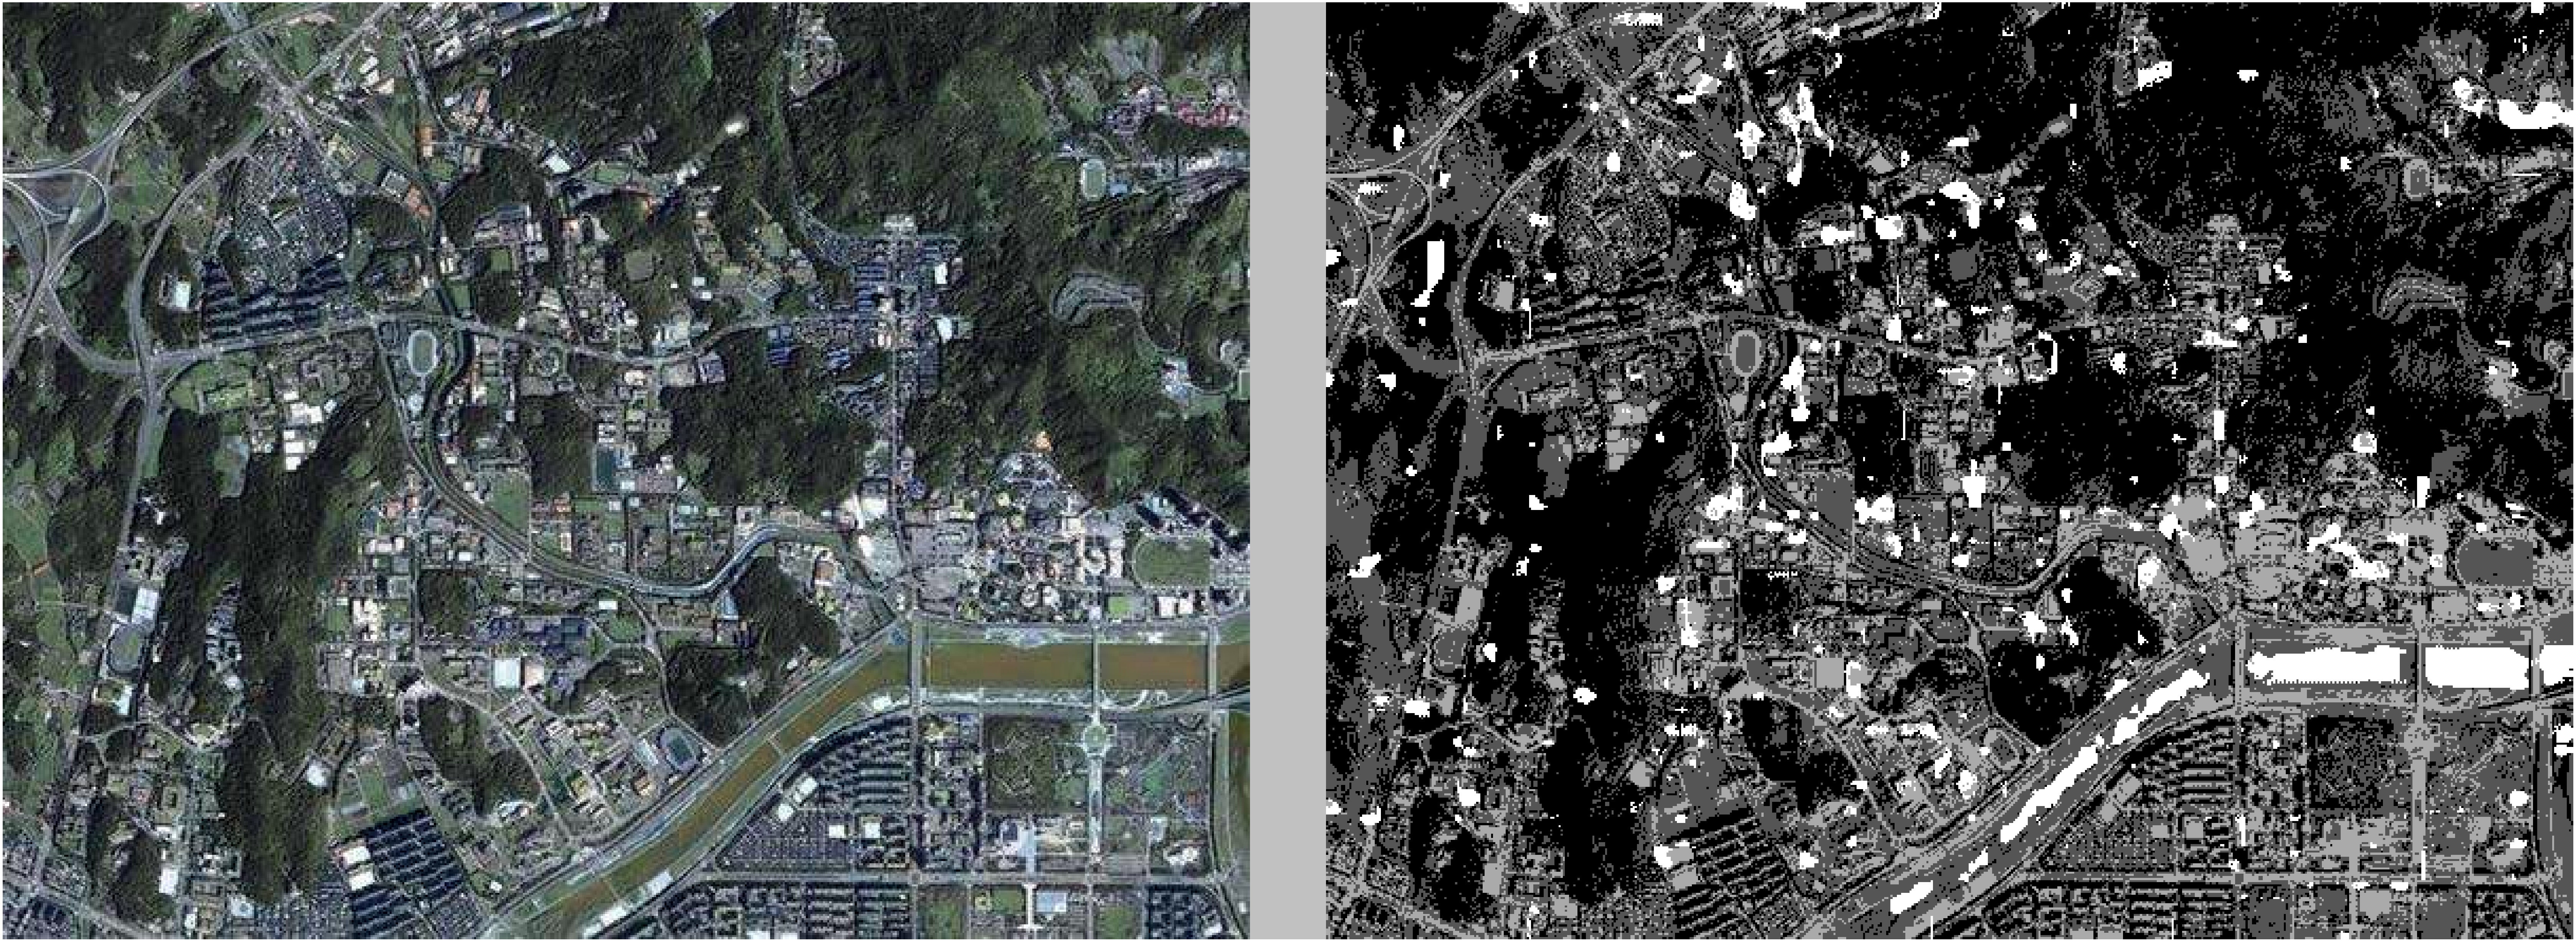

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import argparse
import cv2

ap = argparse.ArgumentParser()
ap.add_argument('-w', '--width', type=int, default = 590)
ap.add_argument('-s', '--color-space', type=str, default = 'hsv')
ap.add_argument('-c', '--channels', type=str, default = '02')
ap.add_argument('-n', '--num-clusters', type=int, default = 4)
ap.add_argument('-o', '--output-file', action = 'store_true')
ap.add_argument('-f', '--output-format', type=str, default = 'png')

args = vars(ap.parse_args())
image = cv2.imread('image.jpg')

if args['width'] > 0:
    height = int((args['width'] / image.shape[1]) * image.shape[0])
    image = cv2.resize(image, (args['width'], height),
        interpolation=cv2.INTER_AREA)
orig = image.copy()

colorSpace = args['color_space'].lower()

if colorSpace == 'hsv':
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
elif colorSpace == 'ycrcb' or colorSpace == 'ycc':
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
elif colorSpace == 'lab':
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
else:
    colorSpace = 'bgr'

if args['channels'] != 'all':
    channels = cv2.split(image)
    channelIndices = []
    for char in args['channels']:
        channelIndices.append(int(char))
    image = image[:,:,channelIndices]
    if len(image.shape) == 2:
        image.reshape(image.shape[0], image.shape[1], 1)

reshaped = image.reshape(image.shape[0] * image.shape[1], image.shape[2])
numClusters = max(2, args['num_clusters'])
kmeans = KMeans(n_clusters=numClusters, n_init=40, max_iter=500).fit(reshaped)
clustering = np.reshape(np.array(kmeans.labels_, dtype=np.uint8), (image.shape[0], image.shape[1]))
sortedLabels = sorted([n for n in range(numClusters)], key=lambda x: -np.sum(clustering == x))
kmeansImage = np.zeros(image.shape[:2], dtype=np.uint8)

for i, label in enumerate(sortedLabels):
    kmeansImage[clustering == label] = int(255 / (numClusters - 1)) * i

concatImage = np.concatenate((orig, 193 * np.ones((orig.shape[0], int(0.0625 * orig.shape[1]), 3), dtype=np.uint8),
    cv2.cvtColor(kmeansImage, cv2.COLOR_GRAY2BGR)), axis=1)

plt.figure(figsize=(120,100))
plt.axis('off')
plt.imshow(concatImage)